In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

In [112]:
## Data variable rename 
def name_ch(input_data):
    #lon=input_data.dims[2]
    #lat=input_data.dims[1]
    #time=input_data.dims[0]
    input_data=input_data.rename({'lat':'latitude'})
    input_data=input_data.rename({'lon':'longitude'})
    input_data=input_data.rename({'time':'time'})
    return input_data

In [121]:
def time_set(data):
    tim=pd.date_range("1-2-1991", periods=len(data.time))
    tim_da = xr.DataArray(tim,[('time',tim)])
    data['time']=tim_da
    return data
def sla_cal(data):
    data['sl']=data.pn/980
    clim=data.sl.sel(time=slice('2000-01-01','2019-12-12')).mean('time')
    data['sla']=data.sl-clim
    data=data.sla
    data=data.where(data<1000)
    return data
def data_proc(data):
    #data=data.pn
    data=name_ch(data)
    data=time_set(data)
    data=sla_cal(data)
    return data

In [4]:
def plot(input_data,title,save):
    lon=input_data[input_data.dims[1]].data
    lat=input_data[input_data.dims[0]].data
    #axs=axs.flatten()
    L2=[-.6,-.5,-.4,-.3,-.2,-.1,-.05,0,.05,.1,.2,.3,.4,.5,.6]
    fig, axs = plt.subplots(nrows=1,ncols=1,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(7,7))
    cs=axs.contourf(lon,lat,input_data,levels=L2,transform = ccrs.PlateCarree(),cmap='seismic',extend='both')
    #axs.setextent([78,100,4,25])
    #axs[1].set_title(year,fontsize = 15, weight='bold')
    axs.coastlines()
    gl = axs.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
    gl.top_labels = False
    gl.bottom_labels = True
    gl.right_labels = False
    gl.left_labels = True
    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)

    plt.suptitle(title,fontsize = 20,weight='bold')
    plt.savefig(save,dpi=120)
    return

## Filtering code ------------------

In [154]:
import scipy.signal as signal
def butterworth_lowpass_filter(data, cutoff_time, axis=0):
    cutoff_freq=1/cutoff_time
    nyfreq=cutoff_freq*2
    order=4
    B, A = signal.butter(order, nyfreq, output="ba")
    return signal.filtfilt(B, A, data, axis=0)

def filter_data(data):
    data_low = butterworth_lowpass_filter(data, 400)
    data_low=xr.DataArray(data_low,coords={"time": data.time, "latitude": data.latitude,
                              "longitude": data.longitude},
                      dims=["time", "latitude","longitude"])
    return data_low

# Altimeter Raw

In [53]:
BoB_altimeter_raw=xr.open_mfdataset("/home/NCAOR/supriyog/raw_data/SL_no_anom/global_SL_and_current_93_19.nc"
                                 ).sel(latitude=slice(4,25),longitude=slice(78,100)).sla

clim=BoB_altimeter_raw.sel(time=slice('2000-01-01','2019-12-30')).mean('time')


<xarray.DataArray 'sla' (time: 9672, latitude: 84, longitude: 88)>
dask.array<getitem, shape=(9672, 84, 88), dtype=float64, chunksize=(9672, 84, 88), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-30
  * longitude  (longitude) float32 78.12 78.38 78.62 78.88 ... 99.38 99.62 99.88
  * latitude   (latitude) float32 4.125 4.375 4.625 4.875 ... 24.38 24.62 24.88
Attributes:
    standard_name:        sea_surface_height_above_sea_level
    long_name:            Sea level anomaly
    units:                m
    grid_mapping:         crs
    ancillary_variables:  err_sla
    comment:              The sea level anomaly is the sea surface height abo...

In [50]:
clim.plot()


KeyboardInterrupt



# Altimeter Unfiltered

In [54]:
BoB_altimeter1=xr.open_mfdataset('/home/NCAOR/supriyog/raw_data/SL_anomaly/IO_SLA_v2021.nc',autoclose=True).sel(latitude=slice(4,25),longitude=slice(78,100)).sla

In [55]:
BoB_altimeter=(BoB_altimeter_raw-clim)*100


In [56]:
BoB_altimeter=name_ch(BoB_altimeter)

In [11]:
BoB_altimeter_new=xr.open_mfdataset('BoB_altimeter_new.nc').sla

('time', 'latitude', 'longitude')


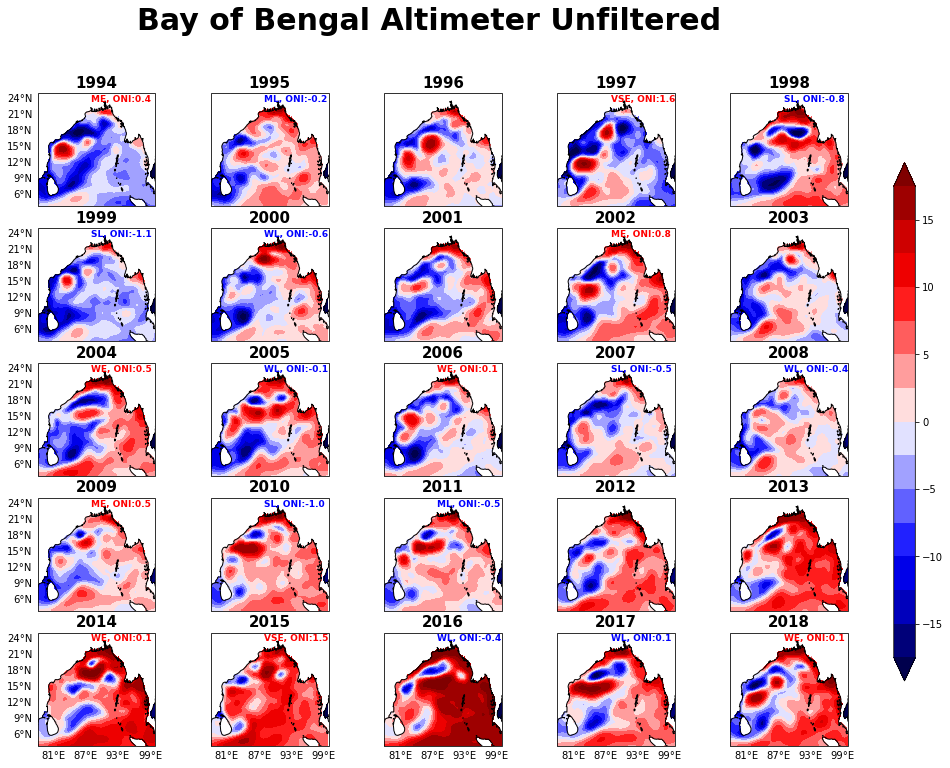

In [43]:
i=BoB_altimeter_new
print(i.dims)
i=name_ch(i)
BoB_plot(i,"Bay of Bengal Altimeter Unfiltered",'BoB_altimeter_unfiltered.jpg')

# LCS Unfilltered data import

In [122]:
lcs_path='/home/NCAOR/supriyog/raw_data/LCSCR_model_output/LCSCR_run_by_supi/LCS_ERA5/'
BoB_LCSCR=xr.open_mfdataset(lcs_path+'LCSCR_final_era5.nc',autoclose=True
                         ).sel(lat=slice(4,25),lon=slice(78,100))
#BoB_LCSCR=BoB_LCSCR.rename({'lon':'longitude'})
#BoB_LCSCR=BoB_LCSCR.rename({'lat':'latitude'})
BoB_LCSCR.dims

Frozen({'lon': 221, 'lat': 211, 'time': 10957})

### LCS Expt data

In [123]:
BoB_LCSCR=xr.open_mfdataset(lcs_path+'LCSCR_final_era5.nc' ).sel(lat=slice(4,25),lon=slice(78,100))
BoB_LCSBI=xr.open_mfdataset(lcs_path+'LCSBI.nc').sel(lat=slice(4,25),lon=slice(78,100))
BoB_LCSEB=xr.open_mfdataset(lcs_path+'LCSEB.nc').sel(lat=slice(4,25),lon=slice(78,100))
BoB_LCSWB=xr.open_mfdataset(lcs_path+'LCSWB.nc').sel(lat=slice(4,25),lon=slice(78,100))
BoB_LCSEIO=xr.open_mfdataset(lcs_path+'LCSEIO.nc').sel(lat=slice(4,25),lon=slice(78,100))



In [124]:
BoB_LCSCR=data_proc(BoB_LCSCR)
BoB_LCSBI=data_proc(BoB_LCSBI)
BoB_LCSEB=data_proc(BoB_LCSEB)
BoB_LCSWB=data_proc(BoB_LCSWB)
BoB_LCSEIO=data_proc(BoB_LCSEIO)

# LCSCR unfilter plot

('time', 'latitude', 'longitude')


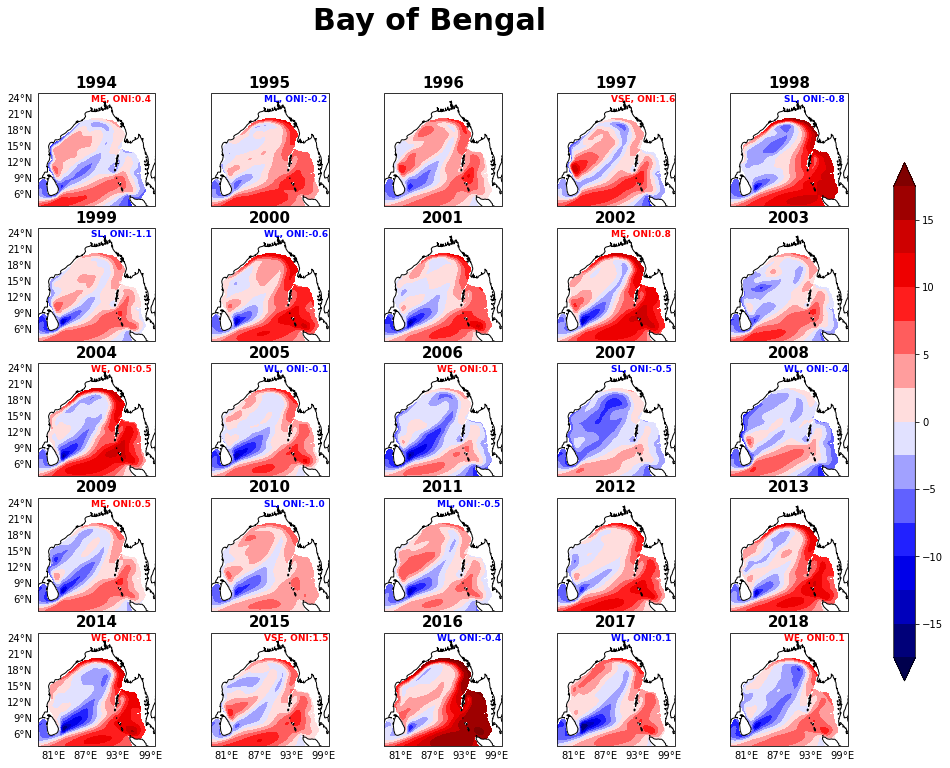

In [175]:
i=BoB_LCSCR
print(i.dims)
BoB_plot(i,"Bay of Bengal",'BoB_LCSCR_unfiltered.jpg')

# Data Filtering

In [ ]:
BoB_altimeter_low = filter_data(BoB_altimeter)
BoB_LCSCR_low = filter_data(BoB_LCSCR)
BoB_LCSWB_low = filter_data(BoB_LCSWB)
BoB_LCSEB_low = filter_data(BoB_LCSEB)
BoB_LCSBI_low = filter_data(BoB_LCSBI)
BoB_LCSEIO_low = filter_data(BoB_LCSEIO)



In [167]:
a=BoB_LCSEIO[100:110]

In [ ]:
#BoB_LCSEIO_low = filter_data(a)
#data_low = butterworth_lowpass_filter(a, 400)

## ferret filtering

In [143]:
BoB_ferret_filtered=name_ch(BoB_ferret_filtered)

## Altimeter filtering in python

In [127]:
BoB_altimeter_low = butterworth_lowpass_filter(BoB_altimeter_new, 400)


In [128]:
BoB_altimeter_low=xr.DataArray(BoB_altimeter_low,coords=
                                   {"time": BoB_altimeter_new.time, "latitude": BoB_altimeter_new.latitude,
                          "longitude": BoB_altimeter_new.longitude},
                  dims=["time", "latitude","longitude"])
BoB_altimeter_low['sla_low']=BoB_altimeter_low
BoB_altimeter_low=BoB_altimeter_low.sla_low

('time', 'latitude', 'longitude')


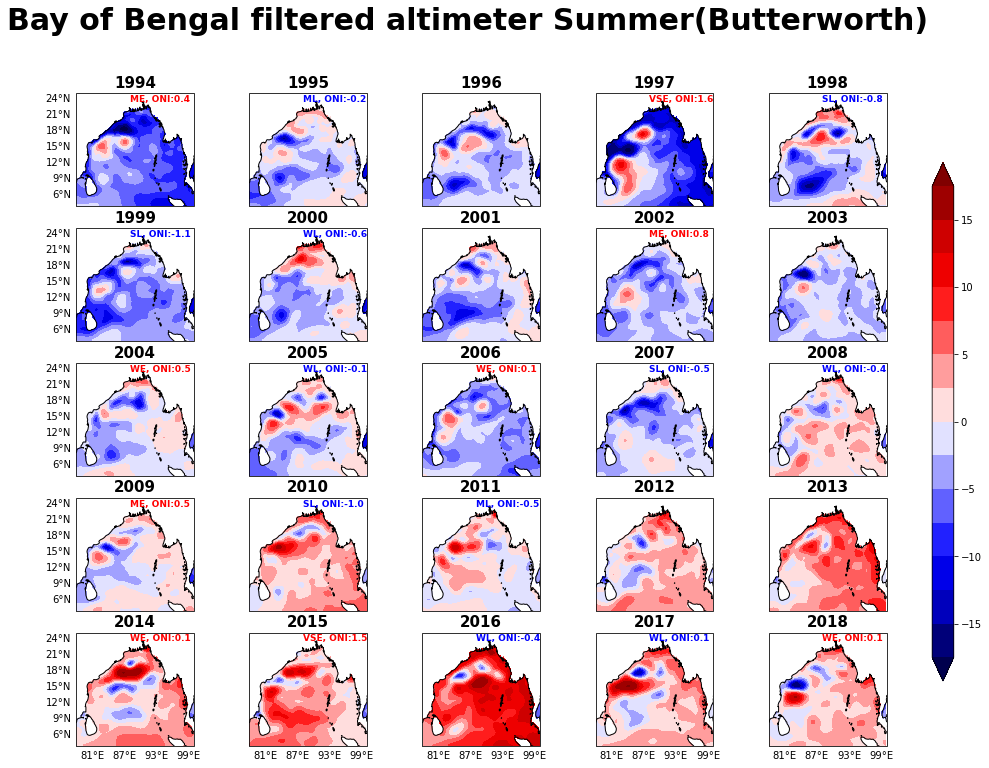

In [16]:
i=BoB_altimeter_low
print(i.dims)
BoB_plot(i,"Bay of Bengal filtered altimeter Summer(Butterworth)",
         'BoB_filtered_altimeter.jpg')

# LCS Filtered

In [147]:
BoB_LCSCR_low = filter_data(BoB_LCSCR)


In [138]:

BoB_LCSCR_low=xr.DataArray(BoB_LCSCR_low,coords={"time": BoB_LCSCR.time, "latitude": BoB_LCSCR.latitude,
                          "longitude": BoB_LCSCR.longitude},
                  dims=["time", "latitude","longitude"])

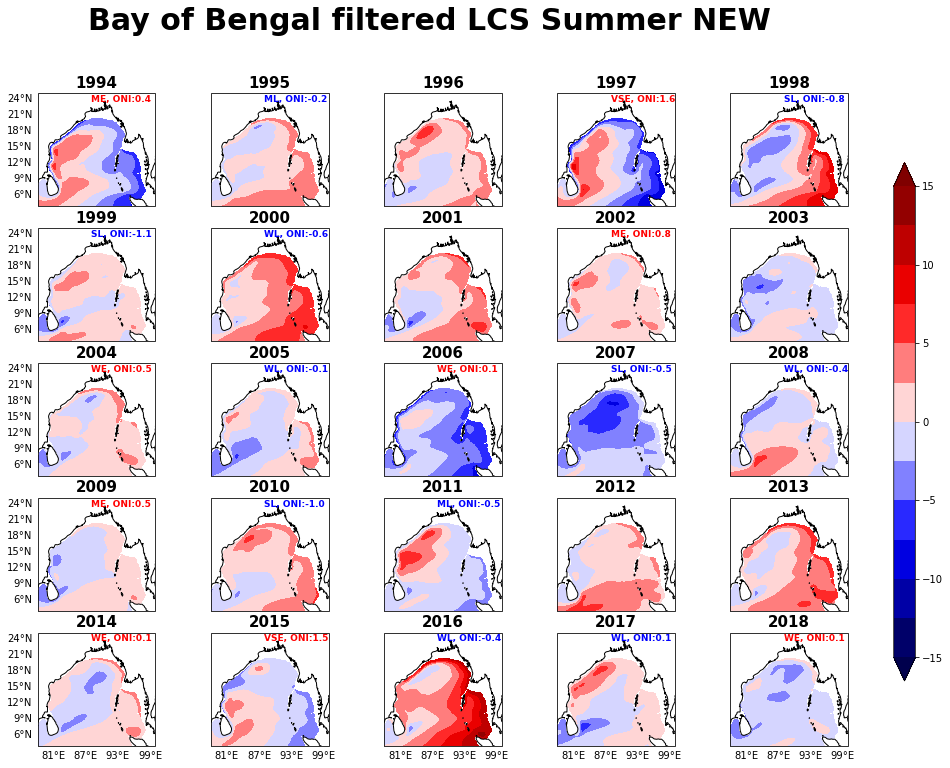

In [187]:
i=BoB_LCSCR_low
#print(i.dims)
BoB_plot(i,"Bay of Bengal filtered LCS Summer NEW",
         'BoB_filtered_LCSCR_new.jpg')

# Correlation

In [277]:
BoB_altimeter1=BoB_altimeter.sel(time=slice('2000-01-01','2010-12-31'))
BoB_altimeter_low1=BoB_altimeter_low.sel(time=slice('2000-01-01','2010-12-31'))
BoB_LCSCR1=BoB_LCSCR.sel(time=slice('2000-01-01','2010-12-31'))
BoB_LCSCR_low1=BoB_LCSCR_low.sel(time=slice('2000-01-01','2010-12-31'))
BoB_LCSCR_low_old1=BoB_LCSCR_low_old.sel(time=slice('2000-01-01','2010-12-31'))


## Correlation of BoB Altimeter and LCS

In [279]:
## first we need to make the model data as altimeter data
BoB_LCSCR_inp1 = BoB_LCSCR1.interp_like(BoB_altimeter1)
BoB_LCSCR_inp1=BoB_LCSCR_inp1.interp(latitude=BoB_altimeter1.latitude, longitude=BoB_altimeter1.longitude)



In [ ]:
i=BoB_LCSCR_inp1
print(i.dims)
#BoB_plot(i,1,2,0,"Bay of Bengal",'test.jpg')

In [280]:
corr_altimter_LCSCR=xr.corr(BoB_altimeter1,BoB_LCSCR_inp1,dim='time')

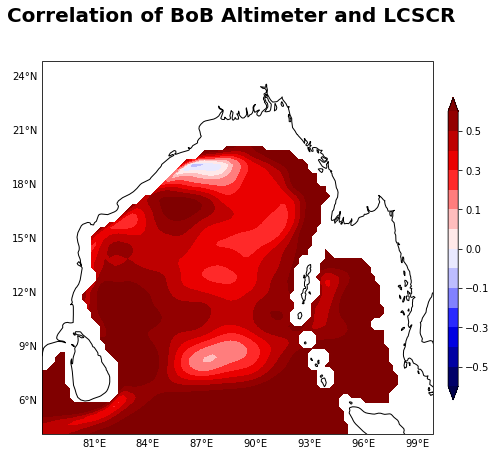

In [281]:
plot(corr_altimter_LCSCR,'Correlation of BoB Altimeter and LCSCR',
    'corr_altimter_LCSCR.jpg')

## Correlation of BoB Altimeter low and LCSCR low

In [282]:
## first we need to make the model data as altimeter data
BoB_LCSCR_low_inp1 = BoB_LCSCR_low1.interp_like(BoB_altimeter_low1)
BoB_LCSCR_low_inp1=BoB_LCSCR_low_inp1.interp(latitude=BoB_altimeter_low1.latitude, 
                                       longitude=BoB_altimeter_low1.longitude)



In [283]:
corr_altimter_LCSCR_low=xr.corr(BoB_altimeter_low1,BoB_LCSCR_low_inp1,dim='time')

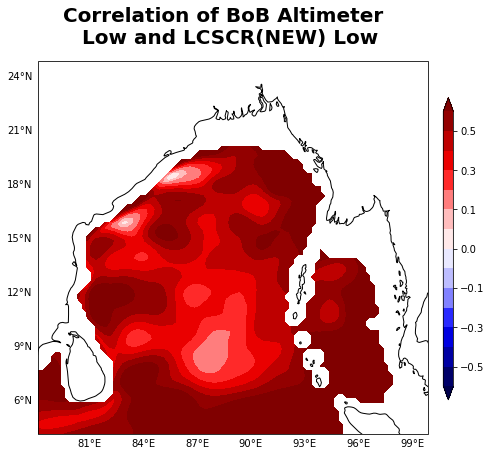

In [284]:
plot(corr_altimter_LCSCR_low,'Correlation of BoB Altimeter \n Low and LCSCR(NEW) Low',
    'corr_altimter_LCSCR_low.jpg')

## Correlation of BoB Altimeter low and LCSCR(OLD) low

In [285]:
## first we need to make the model data as altimeter data
BoB_LCSCR_low_old_inp1 = BoB_LCSCR_low_old1.interp_like(BoB_altimeter_low1)
BoB_LCSCR_low_old_inp1=BoB_LCSCR_low_old_inp1.interp(latitude=BoB_altimeter_low1.latitude, 
                                       longitude=BoB_altimeter_low1.longitude)

BoB_LCSCR_low_old_inp1=BoB_LCSCR_low_old_inp1.drop('ZAXIS1_1')

In [286]:
corr_altimter_LCSCR_old_low=xr.corr(BoB_altimeter_low1,BoB_LCSCR_low_old_inp1,dim='time')

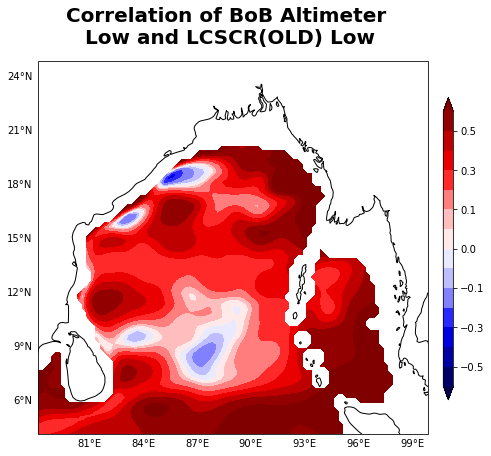

In [287]:
plot(corr_altimter_LCSCR_old_low,'Correlation of BoB Altimeter\n Low and LCSCR(OLD) Low',
    'corr_altimter_LCSCR_low_old.jpg')

## The difference

In [ ]:
diff=corr_altimter_LCSCR_old_low-corr_altimter_LCSCR_low

In [ ]:
plot(diff,'Correlation of BoB Altimeter \n Low and LCSCR(OLD) Low',
    'corr_diff.jpg')

# Point checking 

In [27]:
x1,y1=15,84
x2,y2=17.5,86

In [29]:
input_data=BoB_altimeter_low
input_data=input_data.sel(time=slice('2001-01-01','2004-01-01'))
p1_alt=input_data.sel(latitude=slice(11,12),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p2_alt=input_data.sel(latitude=slice(14,15),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p3_alt=input_data.sel(latitude=slice(17,18),longitude=slice(86,87)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
input_data=BoB_LCSCR_low
input_data=input_data.sel(time=slice('2001-01-01','2004-01-01'))
p1_LCSCR=input_data.sel(latitude=slice(11,12),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p2_LCSCR=input_data.sel(latitude=slice(14,15),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p3_LCSCR=input_data.sel(latitude=slice(17,18),longitude=slice(86,87)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
input_data=BoB_LCSCR_low_old
input_data=input_data.sel(time=slice('2001-01-01','2004-01-01'))
p1_LCSCR_old=input_data.sel(latitude=slice(11,12),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p2_LCSCR_old=input_data.sel(latitude=slice(14,15),longitude=slice(83,84)).mean(dim='latitude').mean(dim='longitude')
p3_LCSCR_old=input_data.sel(latitude=slice(17,18),longitude=slice(86,87)).mean(dim='latitude').mean(dim='longitude')

In [ ]:
print(p1_alt.shape)
p1_LCSCR.shape

In [30]:
fig, ax = plt.subplots(3, 1, sharex=True,figsize=(15,10))
ax[0].plot(p3_alt.coords["time"], p3_alt)
ax[0].plot(p3_LCSCR.coords["time"], p3_LCSCR)
ax[0].plot(p3_LCSCR_old.coords["time"], p3_LCSCR_old)
ax[0].set_title('latitude=(17,18),longitude=(86,87)',fontsize=20)
ax[0].set_ylabel("SLA");
ax[0].legend(['altimeter low','LCS NEW low','LCS OLD low']);

ax[1].plot(p2_alt.coords["time"], p2_alt)
ax[1].plot(p2_LCSCR.coords["time"], p2_LCSCR)
ax[1].plot(p2_LCSCR_old.coords["time"], p2_LCSCR_old)
ax[1].set_title('latitude=(14,15),longitude=(83,84)',fontsize=20)

ax[2].plot(p1_alt.coords["time"], p1_alt)
ax[2].plot(p1_LCSCR.coords["time"], p1_LCSCR)
ax[2].plot(p1_LCSCR_old.coords["time"], p1_LCSCR_old)
ax[2].set_title('latitude=(11,12),longitude=(83,84)',fontsize=20)
plt.savefig('comp.jpg',dpi=130)


Exception ignored in: <function PtyProcess.__del__ at 0x7f64a490a4d0>
Traceback (most recent call last):
  File "/home/NCAOR/supriyog/anaconda3/envs/clim_new/lib/python3.10/site-packages/ptyprocess/ptyprocess.py", line 370, in __del__
    def __del__(self):
KeyboardInterrupt: 

KeyboardInterrupt



Error in callback <function flush_figures at 0x7f6479bdf400> (for post_execute):


KeyboardInterrupt: 

# Decadal change

In [142]:
def season_wise_decadal_data(data):
    clim_99_09 =data.sel(time=slice(
        '1999-01-01','2009-12-30')).groupby(
        'time.month').mean(dim='time')

    clim_10_19 =data.sel(time=slice(
        '2009-01-01','2019-12-30')).groupby(
        'time.month').mean(dim='time')

    ### Summer
    summer_99_09_clim=clim_99_09.sel(month=slice(6,8)).mean(dim='month')  
    summer_10_19_clim=clim_10_19.sel(month=slice(6,8)).mean(dim='month') 
    summer_diff=summer_10_19_clim-summer_99_09_clim

    ### Spring
    spring_99_09_clim=clim_99_09.sel(month=slice(3,5)).mean(dim='month')  
    spring_10_19_clim=clim_10_19.sel(month=slice(3,5)).mean(dim='month')   
    spring_diff=spring_10_19_clim-spring_99_09_clim
    
    ### Autumn
    autumn_99_09_clim=clim_99_09.sel(month=slice(9,11)).mean(dim='month')  
    autumn_10_19_clim=clim_10_19.sel(month=slice(9,11)).mean(dim='month')   
    autumn_diff=autumn_10_19_clim-autumn_99_09_clim

    ### Winter
    winter_99_09_clim=clim_99_09.sel(month=[12,1,2]).mean(dim='month')  
    winter_10_19_clim=clim_10_19.sel(month=[12,1,2]).mean(dim='month') 

    winter_diff=winter_10_19_clim-winter_99_09_clim

    datasets={}
    datasets=dict({'spring_99_09_clim':spring_99_09_clim,
               'spring_10_19_clim':spring_10_19_clim,
               'spring_diff':spring_diff,
                'summer_99_09_clim':summer_99_09_clim,
               'summer_10_19_clim':summer_10_19_clim,
               'summer_diff':summer_diff,
                'autumn_99_09_clim':autumn_99_09_clim,
               'autumn_10_19_clim':autumn_10_19_clim,
               'autumn_diff':autumn_diff,
               'winter_99_09_clim':winter_99_09_clim,
               'winter_10_19_clim':winter_10_19_clim,
               'winter_diff':winter_diff,
               'winter_diff':winter_diff})
    return datasets



In [225]:
altimeter_low_decadal_ds=season_wise_decadal_data(BoB_altimeter_low)
LCSCR_low_decadal_ds=season_wise_decadal_data(BoB_LCSCR_low)
LCSWB_low_decadal_ds=season_wise_decadal_data(BoB_LCSWB_lowlow)
LCSEB_low_decadal_ds=season_wise_decadal_data(BoB_LCSEB_low)
LCSEIO_low_decadal_ds=season_wise_decadal_data(BoB_LCSEIO_low)
LCSBI_low_decadal_ds=season_wise_decadal_data(BoB_LCSBI_low)

## Model Validation

In [216]:

def model_validation_plot(datasets,title,output):

##########  Plotting ###########
    fig, axs = plt.subplots(nrows=4,ncols=6,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    y_label=set([0,6,12,18])
    x_label=set([18,19,20,21,22,23])
    L2=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
    L2=[-5,-4,-3,-2,-1,0,1,2,3,4,5]
    #datasets=clim_data_making(input_data)
    for i,year in enumerate(datasets):
            data=datasets[year]
            cs=axs[i].contourf(data.longitude,data.latitude,data,
                              levels=L2,transform = ccrs.PlateCarree(),
                              cmap='seismic',extend='both')
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 8, weight='bold')
            axs[i].coastlines()
            if i in y_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
           
    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=120)
    
    return 


In [213]:
model_validation_dataset={}
model_validation_dataset=dict({'Altimeter_spring_diff':altimeter_low_decadal_ds['spring_diff'],
              'LCSCR_spring_diff':LCSCR_low_decadal_ds['spring_diff'],
               'Altimeter_spring_99_09_clim':altimeter_low_decadal_ds['spring_99_09_clim'],
               'Altimeter_spring_10_19_clim':altimeter_low_decadal_ds['spring_10_19_clim'],
              'LCSCR_spring_99_09_clim':LCSCR_low_decadal_ds['spring_99_09_clim'],
               'LCSCR_spring_10_19_clim':LCSCR_low_decadal_ds['spring_10_19_clim'],
              
              'Altimeter_summer_diff':altimeter_low_decadal_ds['summer_diff'],
              'LCSCR_summer_diff':LCSCR_low_decadal_ds['summer_diff'],
               'Altimeter_summer_99_09_clim':altimeter_low_decadal_ds['summer_99_09_clim'],
              'Altimeter_summer_10_19_clim':altimeter_low_decadal_ds['summer_10_19_clim'],
              'LCSCR_summer_99_09_clim':LCSCR_low_decadal_ds['summer_99_09_clim'],
               'LCSCR_summer_10_19_clim':LCSCR_low_decadal_ds['summer_10_19_clim'],
               
               'Altimeter_autumn_diff':altimeter_low_decadal_ds['autumn_diff'],
              'LCSCR_autumn_diff':LCSCR_low_decadal_ds['autumn_diff'],
               'Altimeter_autumn_99_09_clim':altimeter_low_decadal_ds['autumn_99_09_clim'],
               'Altimeter_autumn_10_19_clim':altimeter_low_decadal_ds['autumn_10_19_clim'],
              'LCSCR_autumn_99_09_clim':LCSCR_low_decadal_ds['autumn_99_09_clim'],
               'LCSCR_autumn_10_19_clim':LCSCR_low_decadal_ds['autumn_10_19_clim'],
               
               'Altimeter_winter_diff':altimeter_low_decadal_ds['winter_diff'],
              'LCSCR_winter_diff':LCSCR_low_decadal_ds['winter_diff'],
               'Altimeter_winter_99_09_clim':altimeter_low_decadal_ds['winter_99_09_clim'],
               'Altimeter_winter_10_19_clim':altimeter_low_decadal_ds['winter_10_19_clim'],
              'LCSCR_winter_99_09_clim':LCSCR_low_decadal_ds['winter_99_09_clim'],
               'LCSCR_winter_10_19_clim':LCSCR_low_decadal_ds['winter_10_19_clim'],
              })

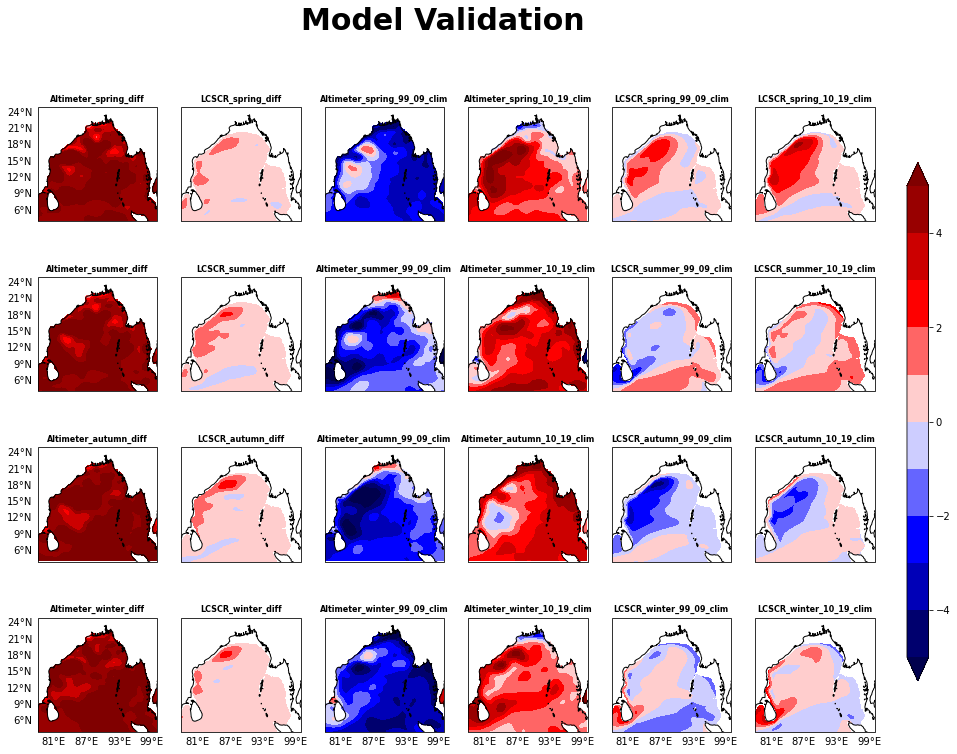

In [217]:
model_validation_plot(model_validation_dataset, 'Model Validation', 'validation.jpg')

## Boundary Experiment

In [229]:
boundary_expt_dataset={}
boundary_expt_dataset=dict({'LCSCR_spring_diff':LCSCR_low_decadal_ds['spring_diff'],
              'LCSBI_spring_diff':LCSBI_low_decadal_ds['spring_diff'],
              'LCSEIO_spring_diff':LCSEIO_low_decadal_ds['spring_diff'],
                'LCSWB_spring_diff':LCSWB_low_decadal_ds['spring_diff'],
                'LCSEB_spring_diff':LCSEB_low_decadal_ds['spring_diff'],
                
                'LCSCR_summer_diff':LCSCR_low_decadal_ds['summer_diff'],
              'LCSBI_summer_diff':LCSBI_low_decadal_ds['summer_diff'],
              'LCSEIO_summer_diff':LCSEIO_low_decadal_ds['summer_diff'],
                'LCSWB_summer_diff':LCSWB_low_decadal_ds['summer_diff'],
                'LCSEB_summer_diff':LCSEB_low_decadal_ds['summer_diff'],
                            
            'LCSCR_autumn_diff':LCSCR_low_decadal_ds['autumn_diff'],
              'LCSBI_autumn_diff':LCSBI_low_decadal_ds['autumn_diff'],
              'LCSEIO_autumn_diff':LCSEIO_low_decadal_ds['autumn_diff'],
                'LCSWB_autumn_diff':LCSWB_low_decadal_ds['autumn_diff'],
                'LCSEB_autumn_diff':LCSEB_low_decadal_ds['autumn_diff'],
                            
                'LCSCR_winter_diff':LCSCR_low_decadal_ds['winter_diff'],
              'LCSBI_winter_diff':LCSBI_low_decadal_ds['winter_diff'],
              'LCSEIO_winter_diff':LCSEIO_low_decadal_ds['winter_diff'],
                'LCSWB_winter_diff':LCSWB_low_decadal_ds['winter_diff'],
                'LCSEB_winter_diff':LCSEB_low_decadal_ds['winter_diff'],
                            
                           })

In [231]:

def boundary_expt_plot(datasets,title,output):

##########  Plotting ###########
    fig, axs = plt.subplots(nrows=4,ncols=6,subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,12))
    axs=axs.flatten()
    y_label=set([0,6,12,18])
    x_label=set([18,19,20,21,22,23])
    L2=[-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0,1,2,3,4,5,6,7,8,9,10]
    L2=[-5,-4,-3,-2,-1,0,1,2,3,4,5]
    #datasets=clim_data_making(input_data)
    for i,year in enumerate(datasets):
            data=datasets[year]
            cs=axs[i].contourf(data.longitude,data.latitude,data,
                              levels=L2,transform = ccrs.PlateCarree(),
                              cmap='seismic',extend='both')
            axs[i].set_extent([78,100,4,25])
            axs[i].set_title(year,fontsize = 8, weight='bold')
            axs[i].coastlines()
            if i in y_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.bottom_labels = False
                gl.right_labels = False
                #gl.xlines=False
            if i in x_label:
                gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,linewidth=0,)
                gl.top_labels = False
                gl.left_labels = False
                gl.right_labels = False
           
    cb_ax=fig.add_axes([0.93,0.2,0.02,0.6])
    cba=fig.colorbar(cs,cax=cb_ax)
    plt.suptitle(title,fontsize = 30,weight='bold')
    plt.savefig(output,dpi=120)
    
    return 


In [ ]:
boundary_expt_plot(boundary_expt_dataset,'Boundary Expt','boundary_expt.jpg')

## JPG to PDF

In [207]:
from PIL import Image
im1 = Image.open(r'BoB_unfiltered_altimeter_clim_diff.jpg')
im2 = Image.open(r'BoB_filtered_altimeter_clim_diff.jpg')
im3 = Image.open(r'BoB_unfiltered_LCS_clim_diff.jpg')
im4 = Image.open(r'BoB_filtered_LCS_clim_diff.jpg')


image_list = [im3,im2,im4]
im1.save(r'figs.pdf', save_all=True, append_images=image_list)


## T test

In [334]:
def t_test_spatial(data):
    clim_99_09 =data.sel(time=slice(
        '1999-01-01','2009-12-30')).groupby(
        'time.dayofyear').mean(dim='time')

    clim_10_19 =data.sel(time=slice(
        '2009-01-01','2019-12-30')).groupby(
        'time.dayofyear').mean(dim='time')

    from scipy.stats import ttest_ind


    stat, p_val = ttest_ind(clim_10_19,clim_99_09)


    df=clim_99_09
    stat=xr.DataArray(stat,coords={"latitude": df.latitude,
                              "longitude": df.longitude},
                      dims=["latitude","longitude"])
    p_val=xr.DataArray(p_val,coords={"latitude": df.latitude,
                              "longitude": df.longitude},
                      dims=["latitude","longitude"])
    return {'stat':stat,'p_val':p_val}

### Altimeter

In [337]:
altimeter_low_ttest=t_test_spatial(BoB_altimeter_low)

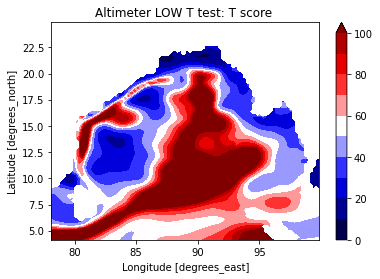

In [350]:
altimeter_low_ttest['stat'].plot.contourf(
    levels=[0,10,20,30,40,50,60,70,80,90,100],cmap='seismic')
plt.title('Altimeter LOW T test: T score ')
plt.savefig('altimeter_low_t_score.jpg',dpi=150)

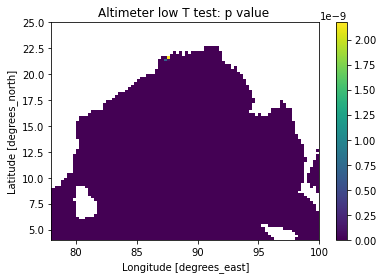

In [358]:
altimeter_low_ttest['p_val'].plot()
plt.title('Altimeter low T test: p value ')
plt.savefig('altimeter_low_p_value.jpg',dpi=150)

### LCS model

In [347]:
lcs_low_ttest=t_test_spatial(BoB_LCSCR_low)

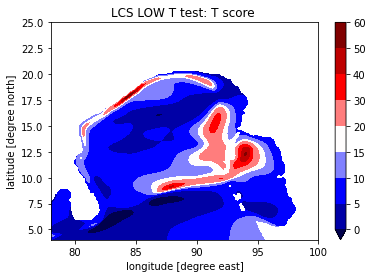

In [351]:
lcs_low_ttest['stat'].plot.contourf(
    levels=[0,5,10,15,20,30,40,50,60],cmap='seismic')
plt.title('LCS LOW T test: T score ')
plt.savefig('lcs_low_t_score.jpg',dpi=150)

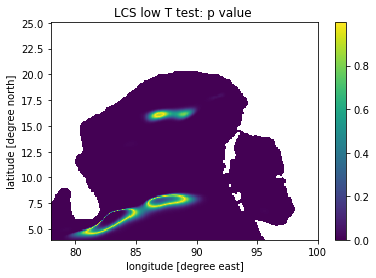

In [355]:
lcs_low_ttest['p_val'].plot()
plt.title('LCS low T test: p value ')
plt.savefig('LCS_low_p_value.jpg',dpi=150)

In [365]:
import pymannkendall as mk
mk.hamed_rao_modification_test(BoB_LCSCR)

Please check your dataset.


UnboundLocalError: local variable 'c' referenced before assignment